#### NES on toy example (supervised learning: classification)

In [1]:
import numpy as np
from numpy import pi, inf 
import pandas as pd
import matplotlib.pyplot as plt
import pickle 
from time import time 

Generate synthetic data

In [116]:
NUM_TRAIN_EXAMPLES = 500
NUM_TEST_EXAMPLES = 100
NUM_FEATURES = 2
NUM_OUTPUTS = 1 

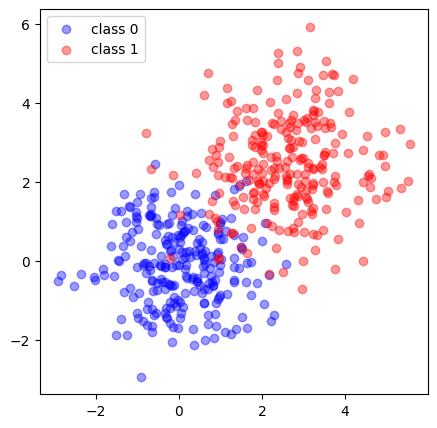

In [117]:
num_train_examples_per_class = int(round(NUM_TRAIN_EXAMPLES/2, 0))
X_train0 = np.random.normal(0.0, 1.0, (num_train_examples_per_class, NUM_FEATURES))
X_train1 = np.random.normal(2.5, 1.2, (num_train_examples_per_class, NUM_FEATURES))
X_train = np.concatenate([X_train0, X_train1])
Y_train = np.concatenate([np.zeros(num_train_examples_per_class), np.ones(num_train_examples_per_class)])

num_test_examples_per_class = int(round(NUM_TEST_EXAMPLES/2, 0))
X_test0 = np.random.normal(0.0, 1.0, (num_test_examples_per_class, NUM_FEATURES))
X_test1 = np.random.normal(2.5, 1.2, (num_test_examples_per_class, NUM_FEATURES))
X_test = np.concatenate([X_test0, X_test1])
Y_test = np.concatenate([np.zeros(num_test_examples_per_class), np.ones(num_test_examples_per_class)])

plt.figure(figsize=(5, 5))
plt.scatter(X_train0[:,0], X_train0[:,1], label="class 0", c="blue", alpha=0.4)
plt.scatter(X_train1[:,0], X_train1[:,1], label="class 1", c="red",  alpha=0.4)
plt.legend();

Model

In [118]:
def model(X, w):
    '''
    W = w.reshape((NUM_OUTPUTS, NUM_FEATURES)) 
    Y = (W @ X.T).T
    return Y
    '''
    z = X @ w
    y = 1/(1+np.exp(-z))  # sigmoid
    return y

Fitting the model using evolution

In [119]:
NUM_OFFSPRING = 10
NUM_GENERATIONS = 5000
dim = NUM_OUTPUTS*NUM_FEATURES  # total number of weights 
# NES:
LR_MEAN = 0.01
LR_LOGSTD = 0.01
# (µ+λ)-ES:
NUM_PARENTS = 1
MUTATION_RATE = 0.1

In [239]:
def evolve1(): 
    """
    Natural Evolution Strategy (NES) 
    """
    # Search distribution 
    search_mean = np.zeros(dim)  # "parent mean"
    # search_logstd = -2.0 * np.ones(dim)  # log std = -2.0 => std ≈ 0.14
    search_logstd = np.zeros(dim)  # "parent log std"
    
    f = -inf * np.ones(NUM_OFFSPRING)  # fitness scores 
    loggrad_mean = np.zeros((NUM_OFFSPRING, dim))
    loggrad_logstd = np.zeros((NUM_OFFSPRING, dim))
    
    history = []
    
    # Run evolution
    for g in range(NUM_GENERATIONS):
        # print("Generation", g)
        search_std = np.exp(search_logstd)
        # Create and evaluate offspring 
        for i in range(NUM_OFFSPRING):
            # Sample 
            w = search_mean + search_std * np.random.randn(dim) 
            # Evaluate 
            f[i] = fitness(X_train, Y_train, w) 
            # Log-gradients of search parameters 
            loggrad_mean[i] = (w-search_mean)/np.multiply(search_std, search_std)
            loggrad_logstd[i] = np.multiply(w-search_mean, w-search_mean)/np.multiply(search_std, search_std)-1
        
        # Normalize fitness scores
        unnorm_f = f
        f = (f-np.mean(f))/(np.std(f)+1e-8)
        
        # Gradients of expected fitness
        grad_J_mean = (f[:, None] * loggrad_mean).mean(axis=0)
        grad_J_logstd = (f[:, None] * loggrad_logstd).mean(axis=0)

        # Fisher matrices
        fisher_mean = np.diag((loggrad_mean ** 2).mean(axis=0))
        fisher_logstd = np.diag((loggrad_logstd ** 2).mean(axis=0))
        
        # Update search parameters 
        search_mean += LR_MEAN * (np.linalg.inv(fisher_mean) @ grad_J_mean)
        search_logstd += LR_LOGSTD * (np.linalg.inv(fisher_logstd) @ grad_J_logstd)

        history.append(unnorm_f.max())
    
    return search_mean, history 

In [126]:
'''
def evolve2(): 
    """
    (µ+λ)-ES algorithm 
    """
    # Initialize
    w_parents = np.random.normal(0, 0.01, (NUM_PARENTS, NUM_FEATURES))  
    f_parents = np.empty(NUM_PARENTS)
    for k in range(NUM_PARENTS):
        f_parents[k] = evaluate(X_train, Y_train, w_parents[k]) 
    
    # Run evolution
    history = []
    w_offspring = np.random.normal(0, 0.01, (NUM_OFFSPRING, NUM_FEATURES))  
    f_offspring = -inf * np.ones(NUM_OFFSPRING)
    for g in range(NUM_GENERATIONS):
        # Create and evaluate offspring 
        k = np.random.randint(NUM_PARENTS, size=NUM_OFFSPRING)  # parent indices 
        noise = np.random.normal(0, MUTATION_RATE, w_parents[k].shape) 
        w_offspring = w_parents[k] + noise 
        f_offspring = np.array([fitness(X_train, Y_train, w_offspring[i]) for i in range(NUM_OFFSPRING)])
        
        # Combine parents and offspring
        weights = np.concatenate((w_parents, w_offspring), axis=0)
        fitness = np.concatenate((f_parents, f_offspring), axis=0)
        
        # Replace parent by best offspring (if better) 
        partition = np.argpartition(-fitness, NUM_PARENTS)[:NUM_PARENTS] 
        j = partition[np.argsort(-fitness[partition])] 
        w_parents = weights[j]
        f_parents = fitness[j]
        print(f_parents)
        history.append(f_parents.mean())
    
    # Save weights of best parent at the end of evolution
    j = np.argmax(f_parents)
    return w_parents[j], history
''';

In [240]:
def fitness(X, Y, w): 
    """
    Negative binary cross entropy 
    """
    Y_pred = model(X, w)
    eps = 1e-12
    Y_pred = np.clip(Y_pred, eps, 1.0-eps)  # for numerical stability 
    scores = -Y*np.log(Y_pred)-(1-Y)*np.log(1-Y_pred)
    score = np.mean(scores)
    # score += np.random.normal(0, ...)  # say, evaluation function is noisy!! 
    return score

CPU times: user 1.11 s, sys: 118 ms, total: 1.23 s
Wall time: 1.17 s


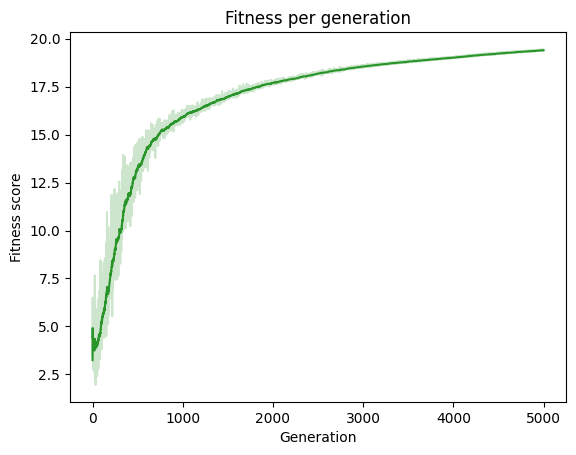

In [241]:
%%time 

w, history = evolve1()

plt.title("Fitness per generation")
plt.xlabel("Generation")
plt.ylabel("Fitness score")
# plt.axhline(0, color="grey", ls="--", alpha=0.3)
plt.plot(history, color="green", alpha=0.2)
ema = pd.Series(history).ewm(alpha=0.05).mean()
plt.plot(ema, color="green", alpha=0.8)

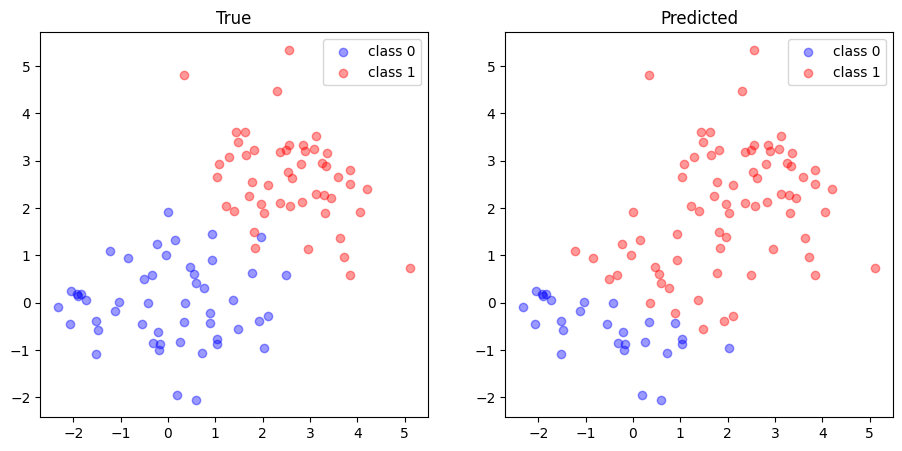

In [242]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 5))

axes[0].set_title("True")
axes[0].scatter(X_test0[:,0], X_test0[:,1], label="class 0", c="blue", alpha=0.4)
axes[0].scatter(X_test1[:,0], X_test1[:,1], label="class 1", c="red",  alpha=0.4)
axes[0].legend();

# Can look non-linear because this only shows first two features
# if there are actually many more features!! 
Y_pred = model(X_test, w)
X_test_pred0 = X_test[Y_pred > 0.5]
X_test_pred1 = X_test[Y_pred <= 0.5]  # 1-Y_pred > 0.5

axes[1].set_title("Predicted")
axes[1].scatter(X_test_pred0[:,0], X_test_pred0[:,1], label="class 0", c="blue", alpha=0.4)
axes[1].scatter(X_test_pred1[:,0], X_test_pred1[:,1], label="class 1", c="red",  alpha=0.4)
axes[1].legend();